<a href="https://colab.research.google.com/github/Vik7am10/ComputerVision/blob/main/DepthEstimation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self Supervised Single Image Monocular Depth Estimation using Neural Networks

Author: Vikram Chandramohan  
Email: v29chand@uwaterloo.ca  


## Abstract

Creating a self-supervised system for monocular depth estimation—the ability to predict a dense depth map from a single RGB image without the use of ground-truth depth labels—is the main objective of this project. This problem is crucial in fields like robotics and autonomous driving, where depth perception is required but active sensors (like LiDAR) are either unavailable or too expensive. This technique enables scalable training on raw image sequences by inferring scene geometry from visual cues across consecutive video frames rather than supervised learning.

The strategy is built on the Monodepth2 framework, a proven way for employing photometric reconstruction loss for self-supervised depth learning. I enhance the basic self-supervised setup by incorporating several key ideas from Monodepth2: multi-scale disparity prediction, automasking for static pixel filtering, and an edge-aware disparity smoothness loss. The experiments are performed on the KITTI Raw dataset using three driving sequences to improve generalization. The final model gives reasonable performance and captures major scene structures without using ground-truth depth labels.

The self-supervised monocular depth estimation technique used in this project is founded on the fundamental ideas of Monodepth2. The system can learn significant 3D structure from unlabelled monocular footage thanks to these design decisions taken together. Even without any explicit guidance, the model is able to accurately capture major depth patterns and scene structure, according to experiments conducted on the KITTI Raw dataset with various driving sequences


## Code Libraries

- PyTorch (functional, torch.nn, torch.nn, torch.nn)
utilised as the fundamental deep learning framework for pose and depth network definition and training. performs backpropagation, loss computation, and tensor manipulations.

- Torchvision (torchvision.models, torchvision.transforms) The pretrained ResNet18 encoder used in the depth network and tools for image preparation (such as scaling, normalisation, and tensor conversion) are provided by Torchvision.

- Pillow (PIL) Before applying transforms, raw RGB picture files from the KITTI dataset are opened and converted into PIL images.

- Matplotlib (matplotlib.pyplot) is used to plot the loss curve over training epochs, visualise input images, and create predicted disparity maps.

- NumPy (numpy) Basic numerical operations such as creating random seeds and smoothing the loss curve are performed.

- OS and glob used for file administration, including managing directory creation and editing and identifying picture paths inside several KITTI drives.

- Math to implement pose_vec_matrix function which converts a 6d Pose Vector into 4*4 SE Transformation Matrix

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import math

import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

class Config:
    img_height = 192
    img_width = 640
    batch_size = 4
    epochs = 10
    lr = 1e-4
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cfg = Config()
print("Using device:", cfg.device)


Using device: cuda


##Dataset Extraction (KITTI)

This cell creates a target directory and extracts multiple KITTI driving sequences from .zip files in Google Drive into the working directory.  
These raw sequences are used as the training data for self-supervised monocular depth estimation.

Please change Path of directory of the zip files if running in different environment

In [ ]:
# target directory
!mkdir -p /content/kitti_raw

# Unzip KITTI files from my Google Drive
!unzip -o "/content/drive/MyDrive/2011_09_26_drive_0001_sync.zip" -d /content/kitti_raw/
!unzip -o "/content/drive/MyDrive/2011_09_26_drive_0009_sync.zip" -d /content/kitti_raw/
!unzip -o "/content/drive/MyDrive/2011_09_26_drive_0011_sync.zip" -d /content/kitti_raw/


Archive:  /content/drive/MyDrive/2011_09_26_drive_0001_sync.zip
   creating: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/timestamps.txt  
   creating: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000017.txt  
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000083.txt  
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000043.txt  
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000059.txt  
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000062.txt  
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000009.txt  
 extracting: /content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/oxts/data/0000000106.txt  
 extract

# Core Components

Multi-Scale Depth Network (DepthNet)
To anticipate disparity maps at various spatial resolutions, an encoder-decoder architecture based on ResNet18 is employed. The model can learn both fine detail and global context thanks to this multi-scale configuration. Depth has an inverse relationship with disparity.

Pose Estimation Network (PoseNet)
Using a concatenation of consecutive frames as input, a lightweight CNN is trained jointly to predict 6-DoF relative camera motion (translation + rotation) between two adjacent frames.

View Synthesis via Warping
Given a predicted depth map for frame
t, and relative poses between t and t +/- 1 we synthesize frame
t by warping its neighbors
t−1 and
t+1 into its viewpoint.

#### This is done by:

-> Projecting the depth map back into the coordinates of a 3D camera

-> Using the posture to transform these points

-> Reprojecting them using camera intrinsics into 2D pixel space

#### Functions of Loss

Photometric Reconstruction Loss measures the difference between the synthesized view and the actual image using a weighted sum of: Structural Similarity Index (SSIM) & L1  loss

By replicating the input image, automasking filters out static or non-moving pixels where reconstruction would be simple. Pixels are retained only when the synthesised view yields a smaller error than identity reconstruction.

By weighting gradients according to the image's inherent edge structure, Disparity Smoothness Loss promotes spatial smoothness in the anticipated disparity maps while maintaining edges.

Multi-Level Monitoring increases training stability and convergence, all losses are calculated at four distinct resolutions and averaged.

#### Training
The KITTI Raw dataset, which includes monocular driving sequences, is used to train the model. To boost generalisation, three sequences are used. With a learning rate of 0.0001, the network is trained across 40 epochs using the Adam optimiser.Progress is tracked by visualising the disparity maps every 2 epochs



## Multi-Sequence KITTI Triplet Dataset Loader

This custom PyTorch Dataset class loads triplets of consecutive frames (t−1, t, t+1) from multiple KITTI driving sequences.  
Each directory in data_dirs corresponds to a drive, and images are resized and transformed before being returned as tensors.  

In [ ]:
# Be able to load from multiple KITTI folders
class MultiKittiDataset(Dataset):
    def __init__(self, data_dirs, transform=None):
        self.all_image_paths = []
        for d in data_dirs:
            imgs = sorted(glob.glob(os.path.join(d, '*.png')))
            self.all_image_paths.extend([
                (imgs[i], imgs[i+1], imgs[i+2])
                for i in range(len(imgs) - 2)
            ])
        self.transform = transform or transforms.Compose([
            transforms.Resize((cfg.img_height, cfg.img_width)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.all_image_paths)

    def __getitem__(self, idx):
        path_t_minus, path_t, path_t_plus = self.all_image_paths[idx]
        img_t_minus = Image.open(path_t_minus).convert('RGB')
        img_t       = Image.open(path_t).convert('RGB')
        img_t_plus  = Image.open(path_t_plus).convert('RGB')

        return {
            't-1': self.transform(img_t_minus),
            't':   self.transform(img_t),
            't+1': self.transform(img_t_plus)
        }


## Dataset Initialization and DataLoader Setup

This cell specifies the list of KITTI drives used for training and initializes the MultiKittiDataset with them.  
A PyTorch DataLoader is used to efficiently batch and shuffle triplet samples during training.


In [ ]:
data_dirs = [
    '/content/kitti_raw/2011_09_26/2011_09_26_drive_0001_sync/image_02/data',
    '/content/kitti_raw/2011_09_26/2011_09_26_drive_0009_sync/image_02/data',
    '/content/kitti_raw/2011_09_26/2011_09_26_drive_0013_sync/image_02/data'
]

kitti_dataset = MultiKittiDataset(data_dirs)
kitti_loader = DataLoader(kitti_dataset, batch_size=cfg.batch_size, shuffle=True)

## Depth Prediction Network (DepthNet)

This is the multi-scale depth prediction network based on ResNet18.  
The encoder extracts hierarchical features from the input image using pretrained ResNet blocks.  
The decoder upsamples these features and outputs four disparity maps at different resolutions.  
This multi-scale output is crucial for computing robust photometric loss at varying levels of detail.


In [ ]:
class DepthNetMultiScale(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)

        # Encoder: using 1 convolution layer to reduce our size
        self.encoder = nn.Sequential(
            resnet.conv1,
            resnet.bn1,
            resnet.relu,
            resnet.maxpool,
            resnet.layer1,
            resnet.layer2,
            resnet.layer3,
            resnet.layer4,
        )

        # Decoder
        self.upconv4 = self._upconv_block(512, 256)
        self.upconv3 = self._upconv_block(256, 128)
        self.upconv2 = self._upconv_block(128, 64)
        self.upconv1 = self._upconv_block(64, 32)

        self.disp4 = self._disp_block(256)
        self.disp3 = self._disp_block(128)
        self.disp2 = self._disp_block(64)
        self.disp1 = self._disp_block(32)

    def _upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True)
        )

    def _disp_block(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        feats = self.encoder(x)

        up4 = self.upconv4(feats)  # 1/16
        up3 = self.upconv3(up4)    # 1/8
        up2 = self.upconv2(up3)    # 1/4
        up1 = self.upconv1(up2)    # 1/2

        d4 = self.disp4(up4)
        d3 = self.disp3(up3)
        d2 = self.disp2(up2)
        d1 = self.disp1(up1)

        return [d1, d2, d3, d4]



## Pose Estimation Network (PoseNet)

This convolutional network predicts relative camera motion (6-DoF pose) between two consecutive frames (e.g., t and t±1).  
It takes a concatenated pair of RGB images as input and outputs a 6D vector representing rotation (Euler angles) and translation.  
This pose is later used to warp context frames into the target view during training.


In [ ]:
class PoseNet(nn.Module):
    def __init__(self, input_channels=6):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),
        )
        self.fc = nn.Linear(128, 6)

    def forward(self, img1, img2):
        # Concatenate along channel dim: [B, 6, H, W]
        x = torch.cat([img1, img2], dim=1)
        x = self.net(x)
        x = x.view(x.size(0), -1)
        pose = self.fc(x)
        return pose


## Pose Vector to Transformation Matrix

This function converts a 6-dimensional pose vector (3 for rotation, 3 for translation) into a 4×4 SE(3) transformation matrix.  
Rotation is computed using Rodrigues’ formula (axis-angle representation), and the translation is stacked to form a full transformation.  
This matrix is used for 3D projection and view synthesis during training.


In [ ]:
def pose_vec_to_matrix(pose_vec):
    batch_size = pose_vec.shape[0]
    rx, ry, rz, tx, ty, tz = pose_vec[:, 0], pose_vec[:, 1], pose_vec[:, 2], pose_vec[:, 3], pose_vec[:, 4], pose_vec[:, 5]

    # Axis and Rotation Angle
    theta = torch.sqrt(rx**2 + ry**2 + rz**2).unsqueeze(1).unsqueeze(2)
    axis = torch.stack([rx, ry, rz], dim=1).unsqueeze(2) / (theta + 1e-8)

    I = torch.eye(3, device=pose_vec.device).unsqueeze(0).repeat(batch_size, 1, 1)
    axis_cross = torch.zeros_like(I)
    axis_cross[:, 0, 1] = -axis[:, 2, 0]
    axis_cross[:, 0, 2] = axis[:, 1, 0]
    axis_cross[:, 1, 0] = axis[:, 2, 0]
    axis_cross[:, 1, 2] = -axis[:, 0, 0]
    axis_cross[:, 2, 0] = -axis[:, 1, 0]
    axis_cross[:, 2, 1] = axis[:, 0, 0]

    R = I + torch.sin(theta) * axis_cross + (1 - torch.cos(theta)) * torch.bmm(axis, axis.transpose(1, 2))

    t = torch.stack([tx, ty, tz], dim=1).unsqueeze(2)  # [B, 3, 1]

    # Combining it into a 4x4 matrix
    Rt = torch.cat([R, t], dim=2)  # [B, 3, 4]
    bottom = torch.tensor([0, 0, 0, 1], dtype=torch.float32, device=pose_vec.device).view(1, 1, 4).repeat(batch_size, 1, 1)
    T = torch.cat([Rt, bottom], dim=1)  # [B, 4, 4]

    return T


## Loss Functions

We implement the losses used in self-supervised depth learning here:
- `masked_photometric_loss`: Applies automasking.
- `disparity_smoothness_loss`: Encourages smooth disparity while respecting image edges.
- `multi_scale_loss`: Computes multi-scale photometric and smoothness loss.


In [ ]:
import torch.nn.functional as F

def make_intrinsics_matrix(batch_size, height, width, device):
    fx = fy = 0.58 * width
    cx = 0.5 * width
    cy = 0.5 * height

    K = torch.tensor([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ], dtype=torch.float32, device=device).unsqueeze(0).repeat(batch_size, 1, 1)

    return K

def compute_ssim(x, y):
    C1 = 0.01**2
    C2 = 0.03**2
    mu_x = F.avg_pool2d(x, 3, 1, 1)
    mu_y = F.avg_pool2d(y, 3, 1, 1)

    sigma_x = F.avg_pool2d(x * x, 3, 1, 1) - mu_x * mu_x
    sigma_y = F.avg_pool2d(y * y, 3, 1, 1) - mu_y * mu_y
    sigma_xy = F.avg_pool2d(x * y, 3, 1, 1) - mu_x * mu_y

    SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
    SSIM_d = (mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2)
    ssim = SSIM_n / SSIM_d
    return torch.clamp((1 - ssim) / 2, 0, 1)

def masked_photometric_loss(warped, target, identity):
    # Photometric loss
    l1_warp = torch.abs(warped - target).mean(1, True)
    ssim_warp = compute_ssim(warped, target)
    photo_loss = 0.85 * ssim_warp + 0.15 * l1_warp

    l1_id = torch.abs(identity - target).mean(1, True)
    ssim_id = compute_ssim(identity, target)
    id_loss = 0.85 * ssim_id + 0.15 * l1_id

    # Automask
    mask = (photo_loss < id_loss).float()
    return (photo_loss * mask).sum() / (mask.sum() + 1e-7)


In [ ]:
def disparity_smoothness_loss(disp, img):
    disp_grad_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    disp_grad_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    img_grad_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    img_grad_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    weight_x = torch.exp(-img_grad_x)
    weight_y = torch.exp(-img_grad_y)

    smoothness_x = disp_grad_x * weight_x
    smoothness_y = disp_grad_y * weight_y

    return (smoothness_x.mean() + smoothness_y.mean())


In [ ]:
def multi_scale_loss(depths, img_t, img_tm1, img_tp1, pose_tm1, pose_tp1, K, smooth_weight=0.001):
    total_loss = 0
    num_scales = len(depths)
    B, _, H, W = img_t.shape

    for i, depth in enumerate(depths):
        _, _, h, w = depth.shape

        img_t_scaled = F.interpolate(img_t, size=(h, w), mode='bilinear', align_corners=False)
        img_tm1_scaled = F.interpolate(img_tm1, size=(h, w), mode='bilinear', align_corners=False)
        img_tp1_scaled = F.interpolate(img_tp1, size=(h, w), mode='bilinear', align_corners=False)

        scale_x = w / W
        scale_y = h / H
        K_scaled = K.clone()
        K_scaled[:, 0, 0] *= scale_x
        K_scaled[:, 1, 1] *= scale_y
        K_scaled[:, 0, 2] *= scale_x
        K_scaled[:, 1, 2] *= scale_y

        warped_tm1 = warp_image(img_tm1_scaled, depth, pose_tm1, K_scaled)
        warped_tp1 = warp_image(img_tp1_scaled, depth, pose_tp1, K_scaled)

        # Automasked photometric loss
        loss_tm1 = masked_photometric_loss(warped_tm1, img_t_scaled, img_tm1_scaled)
        loss_tp1 = masked_photometric_loss(warped_tp1, img_t_scaled, img_tp1_scaled)
        photo_loss = (loss_tm1 + loss_tp1).mean()

        # Smoothness loss
        smooth_loss = disparity_smoothness_loss(depth, img_t_scaled)

        # Total loss
        loss = photo_loss + smooth_weight * smooth_loss
        total_loss += loss

    return total_loss / num_scales


## Backproject Pixel Grid to 3D Camera Coordinates

We implement this function to convert a depth map into 3D camera coordinates using the camera intrinsics matrix.  
Construct a meshgrid of pixel coordinates, backproject them using the inverse of the intrinsics, and scale by the predicted depth to produce 3D points in the camera frame.


In [ ]:
def backproject_depth(batch_depth, K):
    B, _, H, W = batch_depth.shape

    i_range = torch.arange(0, H, device=batch_depth.device).float()
    j_range = torch.arange(0, W, device=batch_depth.device).float()
    jj, ii = torch.meshgrid(j_range, i_range, indexing='xy')
    ones = torch.ones_like(jj)
    pix_coords = torch.stack([jj, ii, ones], dim=0)  # [3, H, W]
    pix_coords = pix_coords.unsqueeze(0).repeat(B, 1, 1, 1)  # [B, 3, H, W]

    pix_coords_flat = pix_coords.view(B, 3, -1)  # [B, 3, H*W]
    inv_K = torch.inverse(K)

    cam_points = torch.bmm(inv_K, pix_coords_flat) * batch_depth.view(B, 1, -1)
    return cam_points, pix_coords_flat


## Projecting 3D Points into a New Camera Frame

We implement this function to take 3D points in the camera coordinate frame and project them into a new view using the predicted pose and camera intrinsics.  
The output is a grid of normalized pixel coordinates in the range [-1, 1], which is required for PyTorch’s grid_sample function used in image warping.


In [ ]:
def project_3d(cam_points, pose, K, height, width):
    B, _, N = cam_points.shape

    ones = torch.ones(B, 1, N, device=cam_points.device)
    cam_points_h = torch.cat([cam_points, ones], dim=1)

    proj_points = torch.bmm(pose, cam_points_h)
    proj_points = proj_points[:, :3, :]  # dropping last row here

    proj_points = torch.bmm(K, proj_points)  # [B, 3, H*W]
    x = proj_points[:, 0, :] / (proj_points[:, 2, :] + 1e-7)
    y = proj_points[:, 1, :] / (proj_points[:, 2, :] + 1e-7)

    x_norm = 2 * (x / (width - 1)) - 1
    y_norm = 2 * (y / (height - 1)) - 1

    pixel_coords = torch.stack([x_norm, y_norm], dim=2)
    return pixel_coords.view(B, height, width, 2)


## View Synthesis: Warp Source Image to Target View

We implement this function to perform view synthesis by warping the source image into the target camera frame using predicted depth and relative pose.  
It backprojects the depth map to 3D points, transforms them using the pose, and reprojects to pixel coordinates used for sampling with grid_sample.


In [ ]:
def warp_image(source_img, depth, pose, K):
    B, _, H, W = depth.shape

    cam_points, _ = backproject_depth(depth, K)
    pixel_coords = project_3d(cam_points, pose, K, H, W)

    # Sample pixels
    warped = F.grid_sample(source_img, pixel_coords, padding_mode='border', align_corners=True)
    return warped


## Single-Batch Training Step with Multi-Scale Depth and Real Warping

This cell runs a one-batch training step using the full Monodepth2-style pipeline.  
It includes multi-scale disparity prediction, real view synthesis via pose and depth,  
and loss computation using photometric consistency and smoothness. This serves as a sanity check before running full training.


In [ ]:
# Instantiate new multi-scale model
depth_net = DepthNetMultiScale().to(cfg.device)
pose_net = PoseNet().to(cfg.device)

optimizer = torch.optim.Adam(list(depth_net.parameters()) + list(pose_net.parameters()), lr=cfg.lr)

# Load one batch from KITTI
batch = next(iter(kitti_loader))
img_t_minus = batch['t-1'].to(cfg.device)
img_t       = batch['t'].to(cfg.device)
img_t_plus  = batch['t+1'].to(cfg.device)

depth_preds = depth_net(img_t)
depths = [1.0 / (d + 1e-6) for d in depth_preds]

pose_minus = pose_net(img_t, img_t_minus)
pose_plus  = pose_net(img_t, img_t_plus)

T_t_to_minus = pose_vec_to_matrix(pose_minus)
T_t_to_plus  = pose_vec_to_matrix(pose_plus)

K = make_intrinsics_matrix(img_t.size(0), cfg.img_height, cfg.img_width, cfg.device)

# Compute total loss
loss = multi_scale_loss(depths, img_t, img_t_minus, img_t_plus, T_t_to_minus, T_t_to_plus, K)

# Learning
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Photometric loss (multi-scale):", loss.item())


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]


Photometric loss (multi-scale): 0.47920817136764526


## Real Warping Test on One Batch (With Multi-Scale Loss)

This cell reinitializes the depth and pose networks and performs a one-batch training step using the full loss pipeline.  
It validates the full integration of disparity prediction, pose estimation, and photometric loss with view synthesis.  
This is typically run before launching the full multi-epoch training loop to ensure correctness.


In [ ]:
# Reinitializing the networks
depth_net = DepthNetMultiScale().to(cfg.device)
pose_net = PoseNet().to(cfg.device)

optimizer = torch.optim.Adam(list(depth_net.parameters()) + list(pose_net.parameters()), lr=cfg.lr)

batch = next(iter(kitti_loader))
img_t_minus = batch['t-1'].to(cfg.device)
img_t       = batch['t'].to(cfg.device)
img_t_plus  = batch['t+1'].to(cfg.device)

depth_preds = depth_net(img_t)
depths = [1.0 / (d + 1e-6) for d in depth_preds]

pose_minus = pose_net(img_t, img_t_minus)
pose_plus  = pose_net(img_t, img_t_plus)
T_t_to_minus = pose_vec_to_matrix(pose_minus)
T_t_to_plus  = pose_vec_to_matrix(pose_plus)

K = make_intrinsics_matrix(img_t.shape[0], cfg.img_height, cfg.img_width, cfg.device)

# Multi-scale photometric loss
loss = multi_scale_loss(depths, img_t, img_t_minus, img_t_plus, T_t_to_minus, T_t_to_plus, K)

# Learning
optimizer.zero_grad()
loss.backward()
optimizer.step()

print("Photometric loss (multi-scale):", loss.item())


Photometric loss (multi-scale): 0.5481473803520203


## Visualize Predicted Disparity from Multi-Scale Model

This cell visualizes the predicted disparity map from the highest-resolution scale of the depth network.  
It displays the original input image alongside the normalized disparity output, helping qualitatively assess model performance.


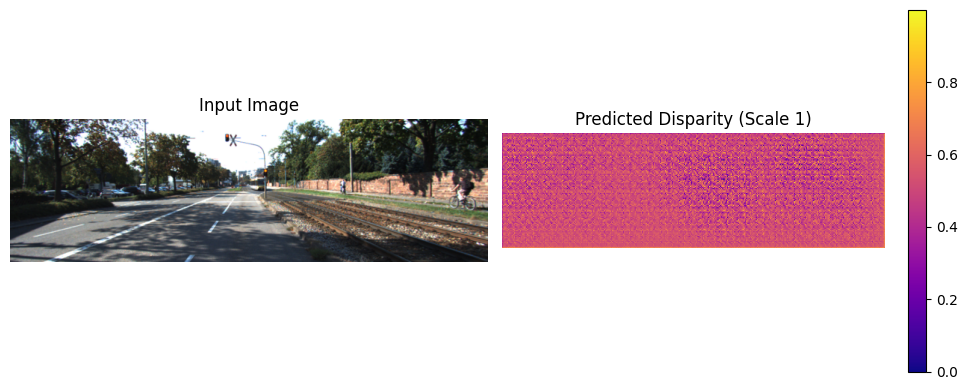

In [ ]:
# Use output from single-batch test in Cell 8
disp_pred = depth_preds[0][0, 0].detach().cpu()  # [H, W]
disp_norm = (disp_pred - disp_pred.min()) / (disp_pred.max() - disp_pred.min() + 1e-8)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(batch['t'][0].permute(1, 2, 0).cpu())
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(disp_norm, cmap='plasma')
plt.title("Predicted Disparity (Scale 1)")
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()


## Full Training Loop (Multi-Scale Depth + Real Warping)

This is the main training loop for the depth and pose networks over 40 epochs.  
It predicts multi-scale disparity maps, estimates poses, computes the total loss (photometric + smoothness), and performs backpropagation.  
Disparity maps are visualized every few epochs to monitor qualitative progress during training.



Epoch 1/40
  Step 0/138 - Loss: 0.5657
  Step 10/138 - Loss: 0.5127
  Step 20/138 - Loss: 0.3623
  Step 30/138 - Loss: 0.3777
  Step 40/138 - Loss: 0.3771
  Step 50/138 - Loss: 0.2898
  Step 60/138 - Loss: 0.3240
  Step 70/138 - Loss: 0.3517
  Step 80/138 - Loss: 0.3310
  Step 90/138 - Loss: 0.3393
  Step 100/138 - Loss: 0.3696
  Step 110/138 - Loss: 0.3451
  Step 120/138 - Loss: 0.3313
  Step 130/138 - Loss: 0.3102
Epoch 1 avg loss: 0.3641

Epoch 2/40
  Step 0/138 - Loss: 0.3343
  Step 10/138 - Loss: 0.3501
  Step 20/138 - Loss: 0.3837
  Step 30/138 - Loss: 0.3531
  Step 40/138 - Loss: 0.3533
  Step 50/138 - Loss: 0.3560
  Step 60/138 - Loss: 0.2572
  Step 70/138 - Loss: 0.3023
  Step 80/138 - Loss: 0.3185
  Step 90/138 - Loss: 0.3315
  Step 100/138 - Loss: 0.2867
  Step 110/138 - Loss: 0.3062
  Step 120/138 - Loss: 0.3094
  Step 130/138 - Loss: 0.3109
Epoch 2 avg loss: 0.3289


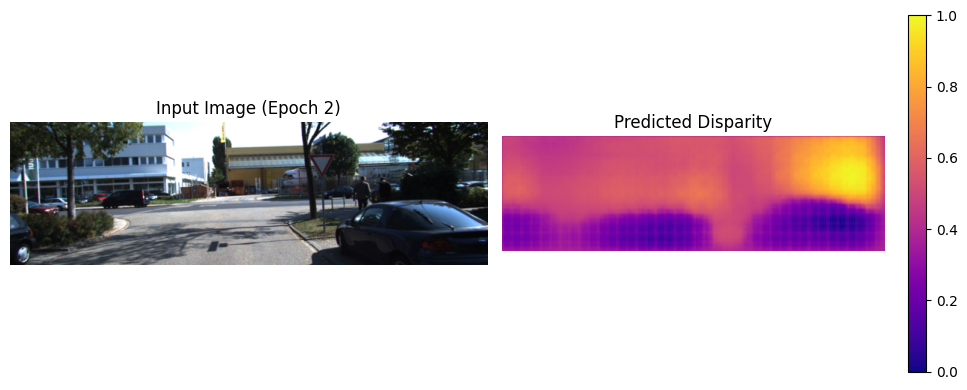


Epoch 3/40
  Step 0/138 - Loss: 0.3173
  Step 10/138 - Loss: 0.2841
  Step 20/138 - Loss: 0.3140
  Step 30/138 - Loss: 0.3304
  Step 40/138 - Loss: 0.3530
  Step 50/138 - Loss: 0.2783
  Step 60/138 - Loss: 0.2925
  Step 70/138 - Loss: 0.3173
  Step 80/138 - Loss: 0.2927
  Step 90/138 - Loss: 0.2996
  Step 100/138 - Loss: 0.2207
  Step 110/138 - Loss: 0.3357
  Step 120/138 - Loss: 0.3343
  Step 130/138 - Loss: 0.2893
Epoch 3 avg loss: 0.3152

Epoch 4/40
  Step 0/138 - Loss: 0.2966
  Step 10/138 - Loss: 0.3041
  Step 20/138 - Loss: 0.3152
  Step 30/138 - Loss: 0.2821
  Step 40/138 - Loss: 0.3774
  Step 50/138 - Loss: 0.3341
  Step 60/138 - Loss: 0.2935
  Step 70/138 - Loss: 0.3151
  Step 80/138 - Loss: 0.2683
  Step 90/138 - Loss: 0.2648
  Step 100/138 - Loss: 0.3079
  Step 110/138 - Loss: 0.3000
  Step 120/138 - Loss: 0.3193
  Step 130/138 - Loss: 0.3619
Epoch 4 avg loss: 0.3064


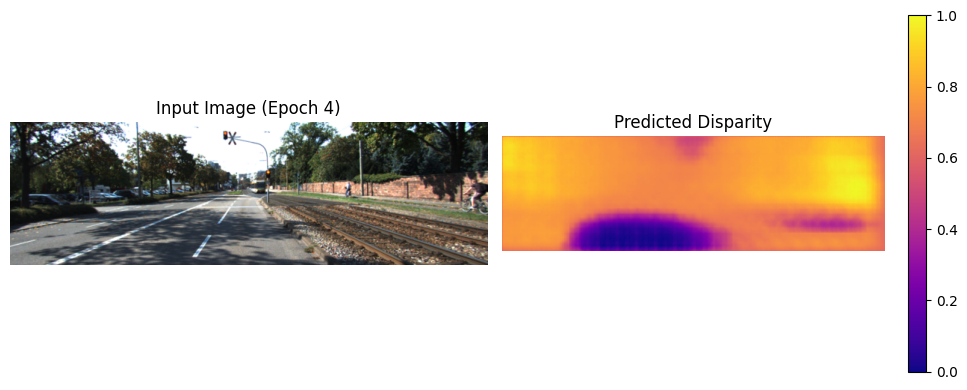


Epoch 5/40
  Step 0/138 - Loss: 0.3042
  Step 10/138 - Loss: 0.3237
  Step 20/138 - Loss: 0.2712
  Step 30/138 - Loss: 0.3447
  Step 40/138 - Loss: 0.2833
  Step 50/138 - Loss: 0.3582
  Step 60/138 - Loss: 0.3006
  Step 70/138 - Loss: 0.2927
  Step 80/138 - Loss: 0.2857
  Step 90/138 - Loss: 0.2865
  Step 100/138 - Loss: 0.2666
  Step 110/138 - Loss: 0.2839
  Step 120/138 - Loss: 0.2640
  Step 130/138 - Loss: 0.3169
Epoch 5 avg loss: 0.3011

Epoch 6/40
  Step 0/138 - Loss: 0.3416
  Step 10/138 - Loss: 0.2668
  Step 20/138 - Loss: 0.3146
  Step 30/138 - Loss: 0.2669
  Step 40/138 - Loss: 0.3018
  Step 50/138 - Loss: 0.3127
  Step 60/138 - Loss: 0.2716
  Step 70/138 - Loss: 0.2751
  Step 80/138 - Loss: 0.3101
  Step 90/138 - Loss: 0.2737
  Step 100/138 - Loss: 0.2661
  Step 110/138 - Loss: 0.3784
  Step 120/138 - Loss: 0.2625
  Step 130/138 - Loss: 0.2767
Epoch 6 avg loss: 0.2964


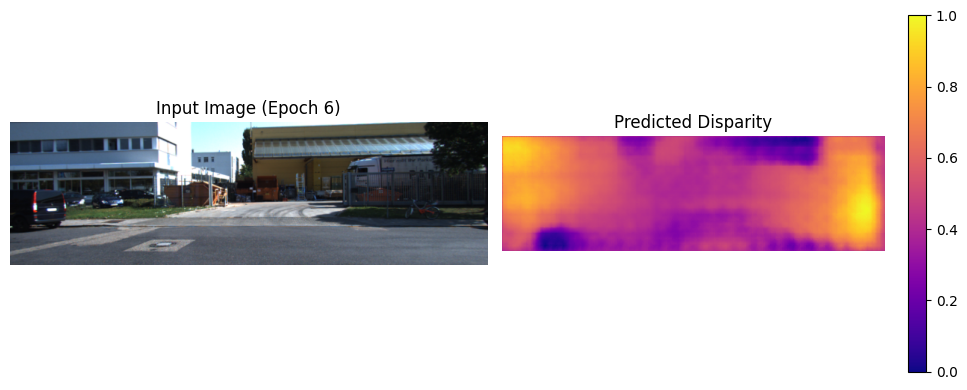


Epoch 7/40
  Step 0/138 - Loss: 0.2839
  Step 10/138 - Loss: 0.2701
  Step 20/138 - Loss: 0.2679
  Step 30/138 - Loss: 0.3006
  Step 40/138 - Loss: 0.2927
  Step 50/138 - Loss: 0.3269
  Step 60/138 - Loss: 0.2961
  Step 70/138 - Loss: 0.2996
  Step 80/138 - Loss: 0.3190
  Step 90/138 - Loss: 0.3125
  Step 100/138 - Loss: 0.3231
  Step 110/138 - Loss: 0.2850
  Step 120/138 - Loss: 0.2869
  Step 130/138 - Loss: 0.3126
Epoch 7 avg loss: 0.2933

Epoch 8/40
  Step 0/138 - Loss: 0.3308
  Step 10/138 - Loss: 0.3295
  Step 20/138 - Loss: 0.2658
  Step 30/138 - Loss: 0.3084
  Step 40/138 - Loss: 0.2972
  Step 50/138 - Loss: 0.3336
  Step 60/138 - Loss: 0.3444
  Step 70/138 - Loss: 0.2967
  Step 80/138 - Loss: 0.2137
  Step 90/138 - Loss: 0.2793
  Step 100/138 - Loss: 0.3137
  Step 110/138 - Loss: 0.3175
  Step 120/138 - Loss: 0.2731
  Step 130/138 - Loss: 0.2885
Epoch 8 avg loss: 0.2883


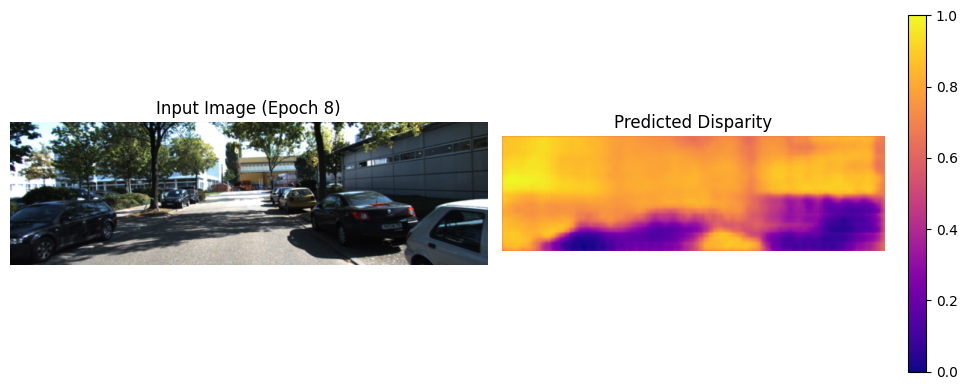


Epoch 9/40
  Step 0/138 - Loss: 0.3491
  Step 10/138 - Loss: 0.2809
  Step 20/138 - Loss: 0.2777
  Step 30/138 - Loss: 0.3268
  Step 40/138 - Loss: 0.2932
  Step 50/138 - Loss: 0.2641
  Step 60/138 - Loss: 0.2961
  Step 70/138 - Loss: 0.2542
  Step 80/138 - Loss: 0.3430
  Step 90/138 - Loss: 0.2584
  Step 100/138 - Loss: 0.2817
  Step 110/138 - Loss: 0.2632
  Step 120/138 - Loss: 0.2614
  Step 130/138 - Loss: 0.3085
Epoch 9 avg loss: 0.2874

Epoch 10/40
  Step 0/138 - Loss: 0.2335
  Step 10/138 - Loss: 0.2665
  Step 20/138 - Loss: 0.2587
  Step 30/138 - Loss: 0.2894
  Step 40/138 - Loss: 0.3290
  Step 50/138 - Loss: 0.2706
  Step 60/138 - Loss: 0.2897
  Step 70/138 - Loss: 0.3084
  Step 80/138 - Loss: 0.3026
  Step 90/138 - Loss: 0.3045
  Step 100/138 - Loss: 0.2924
  Step 110/138 - Loss: 0.2588
  Step 120/138 - Loss: 0.2395
  Step 130/138 - Loss: 0.2827
Epoch 10 avg loss: 0.2860


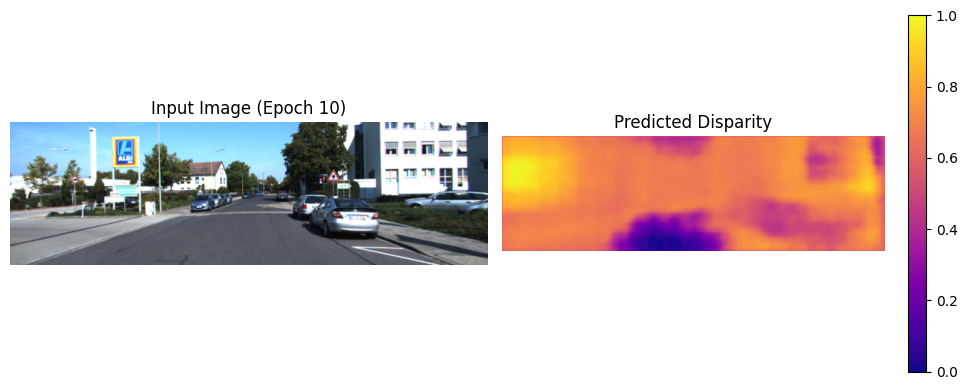


Epoch 11/40
  Step 0/138 - Loss: 0.2804
  Step 10/138 - Loss: 0.3054
  Step 20/138 - Loss: 0.2832
  Step 30/138 - Loss: 0.3002
  Step 40/138 - Loss: 0.2377
  Step 50/138 - Loss: 0.3124
  Step 60/138 - Loss: 0.3035
  Step 70/138 - Loss: 0.2449
  Step 80/138 - Loss: 0.3174
  Step 90/138 - Loss: 0.2948
  Step 100/138 - Loss: 0.2291
  Step 110/138 - Loss: 0.3229
  Step 120/138 - Loss: 0.2807
  Step 130/138 - Loss: 0.2491
Epoch 11 avg loss: 0.2812

Epoch 12/40
  Step 0/138 - Loss: 0.2543
  Step 10/138 - Loss: 0.2978
  Step 20/138 - Loss: 0.2946
  Step 30/138 - Loss: 0.2753
  Step 40/138 - Loss: 0.2314
  Step 50/138 - Loss: 0.2372
  Step 60/138 - Loss: 0.3093
  Step 70/138 - Loss: 0.2469
  Step 80/138 - Loss: 0.2869
  Step 90/138 - Loss: 0.2827
  Step 100/138 - Loss: 0.2945
  Step 110/138 - Loss: 0.2787
  Step 120/138 - Loss: 0.3168
  Step 130/138 - Loss: 0.3120
Epoch 12 avg loss: 0.2779


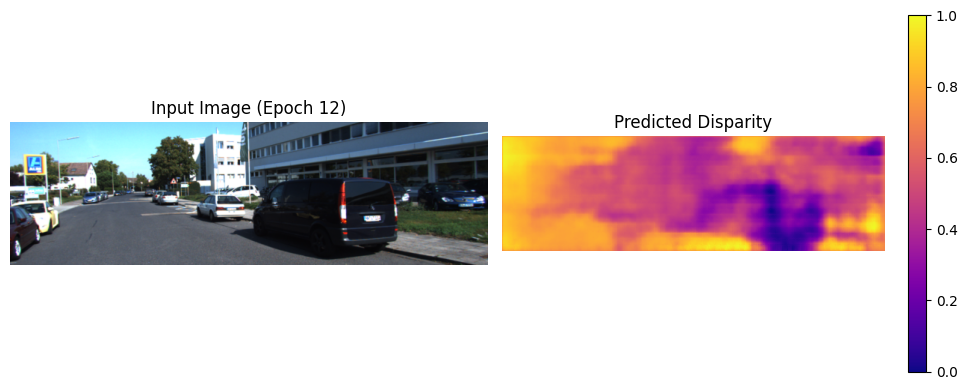


Epoch 13/40
  Step 0/138 - Loss: 0.3093
  Step 10/138 - Loss: 0.3152
  Step 20/138 - Loss: 0.2781
  Step 30/138 - Loss: 0.3078
  Step 40/138 - Loss: 0.2093
  Step 50/138 - Loss: 0.2942
  Step 60/138 - Loss: 0.2692
  Step 70/138 - Loss: 0.2779
  Step 80/138 - Loss: 0.3205
  Step 90/138 - Loss: 0.3148
  Step 100/138 - Loss: 0.2861
  Step 110/138 - Loss: 0.3244
  Step 120/138 - Loss: 0.2559
  Step 130/138 - Loss: 0.3073
Epoch 13 avg loss: 0.2772

Epoch 14/40
  Step 0/138 - Loss: 0.2793
  Step 10/138 - Loss: 0.2544
  Step 20/138 - Loss: 0.2743
  Step 30/138 - Loss: 0.2517
  Step 40/138 - Loss: 0.2409
  Step 50/138 - Loss: 0.2690
  Step 60/138 - Loss: 0.2634
  Step 70/138 - Loss: 0.3049
  Step 80/138 - Loss: 0.2506
  Step 90/138 - Loss: 0.3051
  Step 100/138 - Loss: 0.2375
  Step 110/138 - Loss: 0.2952
  Step 120/138 - Loss: 0.3115
  Step 130/138 - Loss: 0.2697
Epoch 14 avg loss: 0.2752


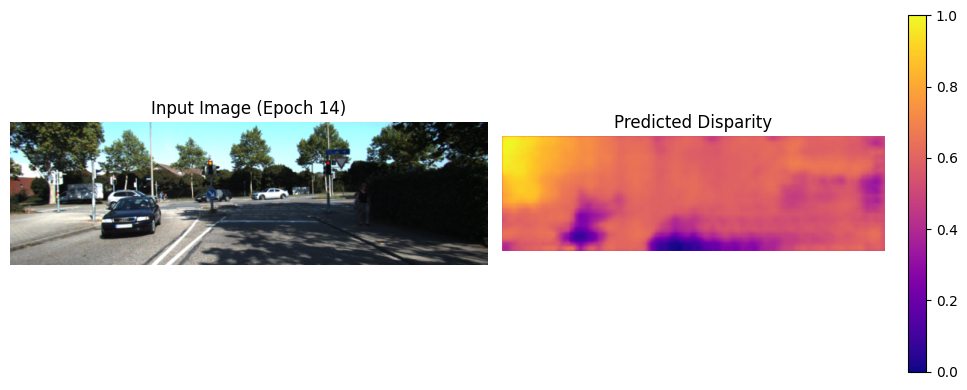


Epoch 15/40
  Step 0/138 - Loss: 0.2745
  Step 10/138 - Loss: 0.2938
  Step 20/138 - Loss: 0.2669
  Step 30/138 - Loss: 0.2686
  Step 40/138 - Loss: 0.2712
  Step 50/138 - Loss: 0.2575
  Step 60/138 - Loss: 0.3102
  Step 70/138 - Loss: 0.2763
  Step 80/138 - Loss: 0.2885
  Step 90/138 - Loss: 0.2779
  Step 100/138 - Loss: 0.2594
  Step 110/138 - Loss: 0.2877
  Step 120/138 - Loss: 0.2513
  Step 130/138 - Loss: 0.2618
Epoch 15 avg loss: 0.2741

Epoch 16/40
  Step 0/138 - Loss: 0.2554
  Step 10/138 - Loss: 0.2810
  Step 20/138 - Loss: 0.3105
  Step 30/138 - Loss: 0.2560
  Step 40/138 - Loss: 0.2415
  Step 50/138 - Loss: 0.2174
  Step 60/138 - Loss: 0.3050
  Step 70/138 - Loss: 0.2396
  Step 80/138 - Loss: 0.2461
  Step 90/138 - Loss: 0.2431
  Step 100/138 - Loss: 0.2279
  Step 110/138 - Loss: 0.2415
  Step 120/138 - Loss: 0.2961
  Step 130/138 - Loss: 0.3189
Epoch 16 avg loss: 0.2711


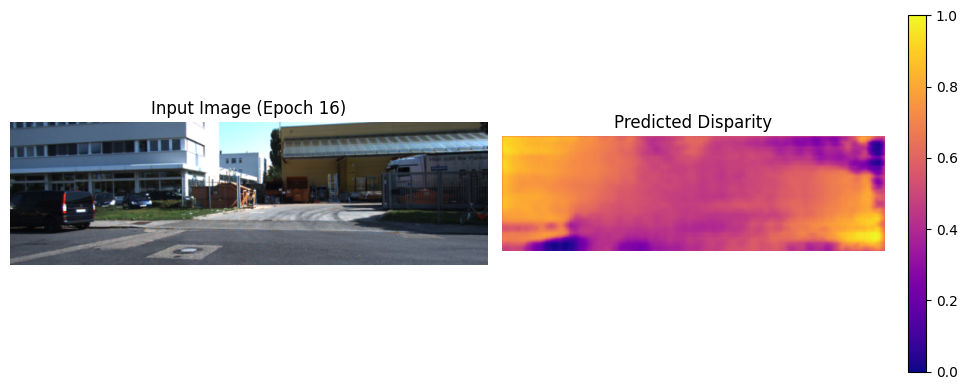


Epoch 17/40
  Step 0/138 - Loss: 0.2798
  Step 10/138 - Loss: 0.2601
  Step 20/138 - Loss: 0.2768
  Step 30/138 - Loss: 0.2708
  Step 40/138 - Loss: 0.2363
  Step 50/138 - Loss: 0.3109
  Step 60/138 - Loss: 0.2994
  Step 70/138 - Loss: 0.2844
  Step 80/138 - Loss: 0.2933
  Step 90/138 - Loss: 0.2268
  Step 100/138 - Loss: 0.2832
  Step 110/138 - Loss: 0.2949
  Step 120/138 - Loss: 0.2842
  Step 130/138 - Loss: 0.2741
Epoch 17 avg loss: 0.2693

Epoch 18/40
  Step 0/138 - Loss: 0.2625
  Step 10/138 - Loss: 0.2769
  Step 20/138 - Loss: 0.2699
  Step 30/138 - Loss: 0.2970
  Step 40/138 - Loss: 0.2249
  Step 50/138 - Loss: 0.2658
  Step 60/138 - Loss: 0.2109
  Step 70/138 - Loss: 0.2678
  Step 80/138 - Loss: 0.2899
  Step 90/138 - Loss: 0.3454
  Step 100/138 - Loss: 0.2791
  Step 110/138 - Loss: 0.2805
  Step 120/138 - Loss: 0.2447
  Step 130/138 - Loss: 0.2651
Epoch 18 avg loss: 0.2659


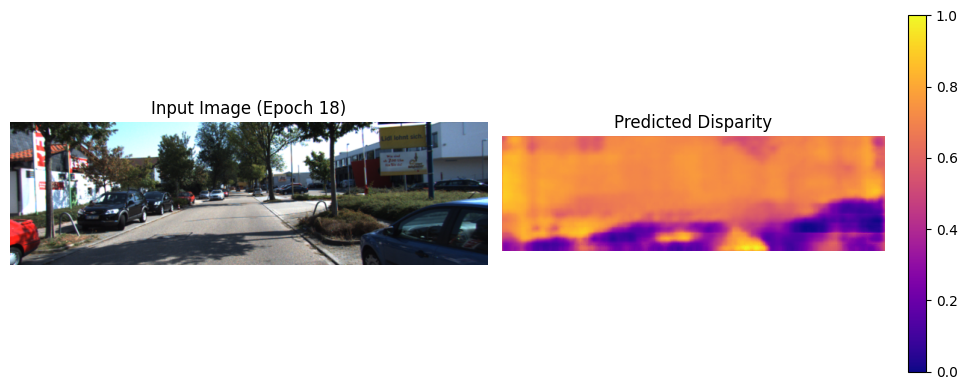


Epoch 19/40
  Step 0/138 - Loss: 0.2739
  Step 10/138 - Loss: 0.2597
  Step 20/138 - Loss: 0.2650
  Step 30/138 - Loss: 0.2281
  Step 40/138 - Loss: 0.2430
  Step 50/138 - Loss: 0.2441
  Step 60/138 - Loss: 0.3246
  Step 70/138 - Loss: 0.2645
  Step 80/138 - Loss: 0.2362
  Step 90/138 - Loss: 0.2681
  Step 100/138 - Loss: 0.3104
  Step 110/138 - Loss: 0.2341
  Step 120/138 - Loss: 0.3033
  Step 130/138 - Loss: 0.1888
Epoch 19 avg loss: 0.2655

Epoch 20/40
  Step 0/138 - Loss: 0.2940
  Step 10/138 - Loss: 0.2543
  Step 20/138 - Loss: 0.2316
  Step 30/138 - Loss: 0.2597
  Step 40/138 - Loss: 0.2334
  Step 50/138 - Loss: 0.2383
  Step 60/138 - Loss: 0.2318
  Step 70/138 - Loss: 0.3118
  Step 80/138 - Loss: 0.2337
  Step 90/138 - Loss: 0.2770
  Step 100/138 - Loss: 0.2675
  Step 110/138 - Loss: 0.2553
  Step 120/138 - Loss: 0.2461
  Step 130/138 - Loss: 0.2532
Epoch 20 avg loss: 0.2638


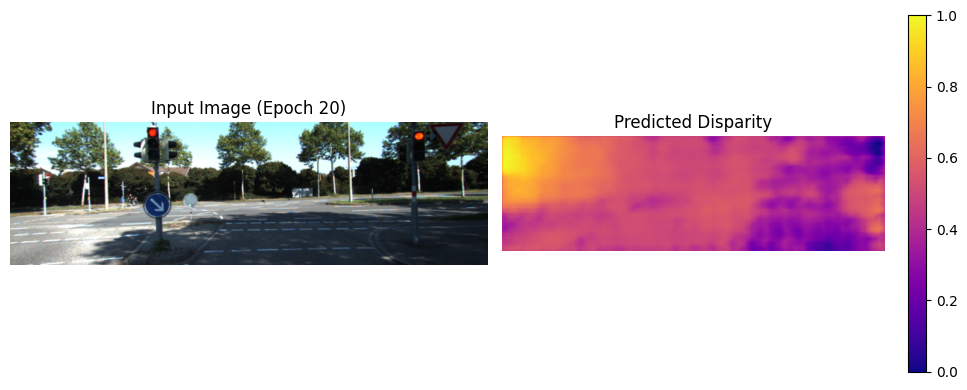


Epoch 21/40
  Step 0/138 - Loss: 0.2249
  Step 10/138 - Loss: 0.2815
  Step 20/138 - Loss: 0.3220
  Step 30/138 - Loss: 0.3429
  Step 40/138 - Loss: 0.2981
  Step 50/138 - Loss: 0.2286
  Step 60/138 - Loss: 0.2490
  Step 70/138 - Loss: 0.2454
  Step 80/138 - Loss: 0.2445
  Step 90/138 - Loss: 0.3222
  Step 100/138 - Loss: 0.2973
  Step 110/138 - Loss: 0.2688
  Step 120/138 - Loss: 0.2413
  Step 130/138 - Loss: 0.2471
Epoch 21 avg loss: 0.2630

Epoch 22/40
  Step 0/138 - Loss: 0.2430
  Step 10/138 - Loss: 0.2078
  Step 20/138 - Loss: 0.2232
  Step 30/138 - Loss: 0.2556
  Step 40/138 - Loss: 0.2767
  Step 50/138 - Loss: 0.2275
  Step 60/138 - Loss: 0.2908
  Step 70/138 - Loss: 0.2555
  Step 80/138 - Loss: 0.3008
  Step 90/138 - Loss: 0.2867
  Step 100/138 - Loss: 0.2636
  Step 110/138 - Loss: 0.3212
  Step 120/138 - Loss: 0.2444
  Step 130/138 - Loss: 0.2614
Epoch 22 avg loss: 0.2613


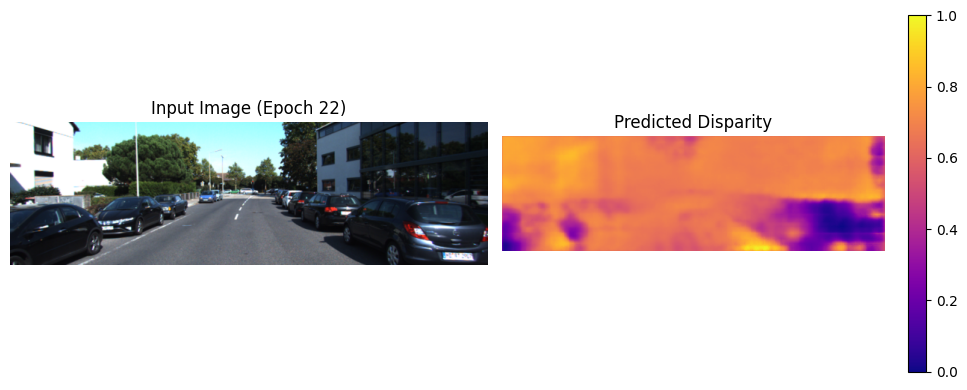


Epoch 23/40
  Step 0/138 - Loss: 0.2833
  Step 10/138 - Loss: 0.2591
  Step 20/138 - Loss: 0.3162
  Step 30/138 - Loss: 0.2953
  Step 40/138 - Loss: 0.2863
  Step 50/138 - Loss: 0.2349
  Step 60/138 - Loss: 0.2508
  Step 70/138 - Loss: 0.2663
  Step 80/138 - Loss: 0.2528
  Step 90/138 - Loss: 0.2661
  Step 100/138 - Loss: 0.2654
  Step 110/138 - Loss: 0.2373
  Step 120/138 - Loss: 0.2571
  Step 130/138 - Loss: 0.2229
Epoch 23 avg loss: 0.2596

Epoch 24/40
  Step 0/138 - Loss: 0.2236
  Step 10/138 - Loss: 0.2405
  Step 20/138 - Loss: 0.2712
  Step 30/138 - Loss: 0.2361
  Step 40/138 - Loss: 0.2995
  Step 50/138 - Loss: 0.3015
  Step 60/138 - Loss: 0.2519
  Step 70/138 - Loss: 0.2763
  Step 80/138 - Loss: 0.2709
  Step 90/138 - Loss: 0.2212
  Step 100/138 - Loss: 0.2524
  Step 110/138 - Loss: 0.2636
  Step 120/138 - Loss: 0.2711
  Step 130/138 - Loss: 0.2804
Epoch 24 avg loss: 0.2576


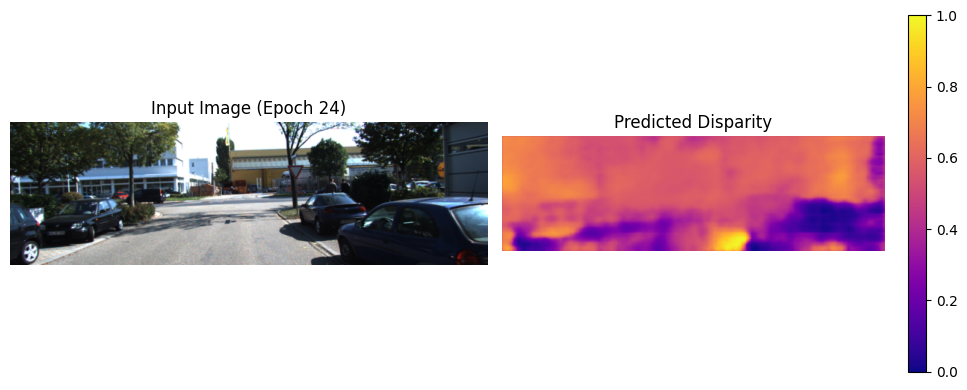


Epoch 25/40
  Step 0/138 - Loss: 0.2295
  Step 10/138 - Loss: 0.2540
  Step 20/138 - Loss: 0.2223
  Step 30/138 - Loss: 0.2286
  Step 40/138 - Loss: 0.2745
  Step 50/138 - Loss: 0.2889
  Step 60/138 - Loss: 0.2874
  Step 70/138 - Loss: 0.2576
  Step 80/138 - Loss: 0.2644
  Step 90/138 - Loss: 0.2755
  Step 100/138 - Loss: 0.2683
  Step 110/138 - Loss: 0.1954
  Step 120/138 - Loss: 0.2683
  Step 130/138 - Loss: 0.3091
Epoch 25 avg loss: 0.2577

Epoch 26/40
  Step 0/138 - Loss: 0.1908
  Step 10/138 - Loss: 0.2856
  Step 20/138 - Loss: 0.2605
  Step 30/138 - Loss: 0.2623
  Step 40/138 - Loss: 0.2356
  Step 50/138 - Loss: 0.2839
  Step 60/138 - Loss: 0.2406
  Step 70/138 - Loss: 0.2624
  Step 80/138 - Loss: 0.2497
  Step 90/138 - Loss: 0.2640
  Step 100/138 - Loss: 0.2842
  Step 110/138 - Loss: 0.2484
  Step 120/138 - Loss: 0.2793
  Step 130/138 - Loss: 0.2605
Epoch 26 avg loss: 0.2552


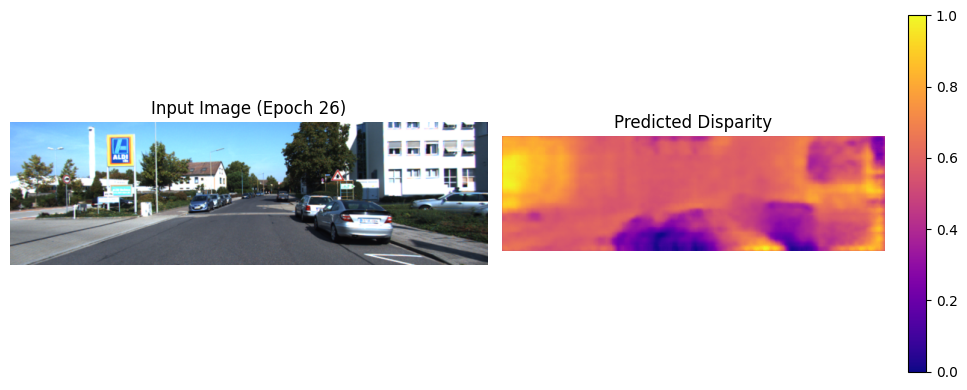


Epoch 27/40
  Step 0/138 - Loss: 0.2209
  Step 10/138 - Loss: 0.2368
  Step 20/138 - Loss: 0.2684
  Step 30/138 - Loss: 0.2401
  Step 40/138 - Loss: 0.2644
  Step 50/138 - Loss: 0.2481
  Step 60/138 - Loss: 0.2696
  Step 70/138 - Loss: 0.2093
  Step 80/138 - Loss: 0.2388
  Step 90/138 - Loss: 0.2792
  Step 100/138 - Loss: 0.2462
  Step 110/138 - Loss: 0.2248
  Step 120/138 - Loss: 0.2724
  Step 130/138 - Loss: 0.2578
Epoch 27 avg loss: 0.2537

Epoch 28/40
  Step 0/138 - Loss: 0.2231
  Step 10/138 - Loss: 0.2498
  Step 20/138 - Loss: 0.2240
  Step 30/138 - Loss: 0.2894
  Step 40/138 - Loss: 0.2441
  Step 50/138 - Loss: 0.2399
  Step 60/138 - Loss: 0.2630
  Step 70/138 - Loss: 0.2477
  Step 80/138 - Loss: 0.2330
  Step 90/138 - Loss: 0.2125
  Step 100/138 - Loss: 0.2731
  Step 110/138 - Loss: 0.2016
  Step 120/138 - Loss: 0.2381
  Step 130/138 - Loss: 0.2600
Epoch 28 avg loss: 0.2527


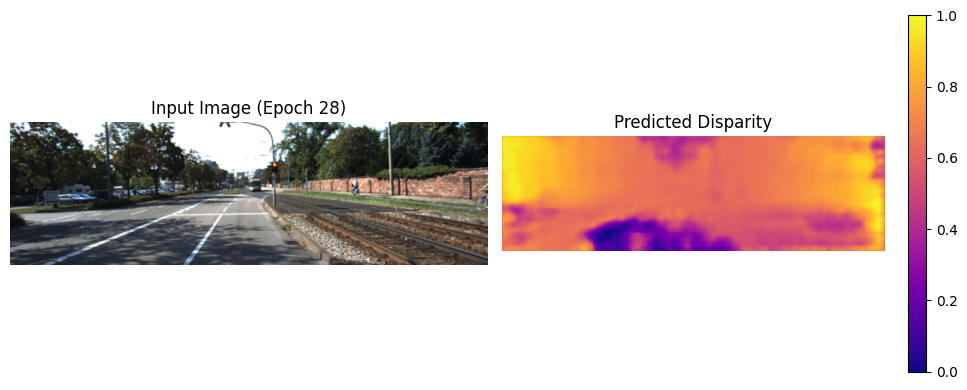


Epoch 29/40
  Step 0/138 - Loss: 0.2218
  Step 10/138 - Loss: 0.3085
  Step 20/138 - Loss: 0.2398
  Step 30/138 - Loss: 0.2373
  Step 40/138 - Loss: 0.2553
  Step 50/138 - Loss: 0.2094
  Step 60/138 - Loss: 0.2022
  Step 70/138 - Loss: 0.2617
  Step 80/138 - Loss: 0.2336
  Step 90/138 - Loss: 0.2674
  Step 100/138 - Loss: 0.2990
  Step 110/138 - Loss: 0.1979
  Step 120/138 - Loss: 0.2449
  Step 130/138 - Loss: 0.2955
Epoch 29 avg loss: 0.2531

Epoch 30/40
  Step 0/138 - Loss: 0.2518
  Step 10/138 - Loss: 0.2265
  Step 20/138 - Loss: 0.2879
  Step 30/138 - Loss: 0.2888
  Step 40/138 - Loss: 0.2280
  Step 50/138 - Loss: 0.2506
  Step 60/138 - Loss: 0.2523
  Step 70/138 - Loss: 0.3188
  Step 80/138 - Loss: 0.2570
  Step 90/138 - Loss: 0.2558
  Step 100/138 - Loss: 0.2403
  Step 110/138 - Loss: 0.2664
  Step 120/138 - Loss: 0.2792
  Step 130/138 - Loss: 0.2458
Epoch 30 avg loss: 0.2510


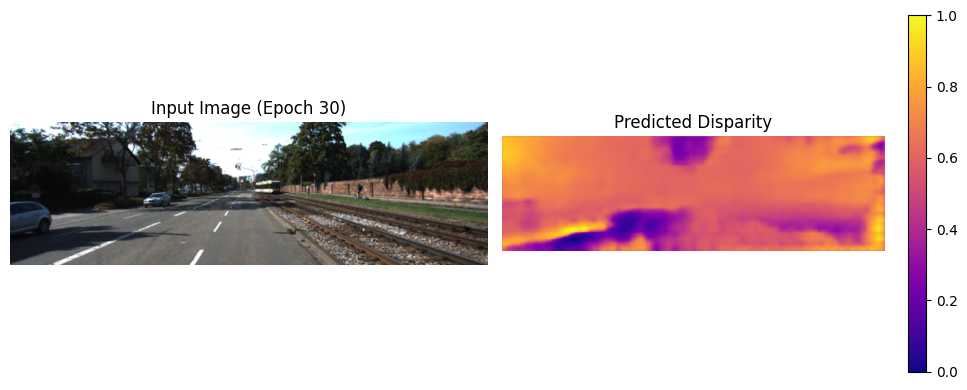


Epoch 31/40
  Step 0/138 - Loss: 0.2891
  Step 10/138 - Loss: 0.2484
  Step 20/138 - Loss: 0.2410
  Step 30/138 - Loss: 0.2712
  Step 40/138 - Loss: 0.1831
  Step 50/138 - Loss: 0.2217
  Step 60/138 - Loss: 0.2178
  Step 70/138 - Loss: 0.2435
  Step 80/138 - Loss: 0.2269
  Step 90/138 - Loss: 0.2046
  Step 100/138 - Loss: 0.2310
  Step 110/138 - Loss: 0.2500
  Step 120/138 - Loss: 0.2569
  Step 130/138 - Loss: 0.2232
Epoch 31 avg loss: 0.2494

Epoch 32/40
  Step 0/138 - Loss: 0.2426
  Step 10/138 - Loss: 0.2228
  Step 20/138 - Loss: 0.2596
  Step 30/138 - Loss: 0.2438
  Step 40/138 - Loss: 0.2288
  Step 50/138 - Loss: 0.2736
  Step 60/138 - Loss: 0.2415
  Step 70/138 - Loss: 0.2554
  Step 80/138 - Loss: 0.2431
  Step 90/138 - Loss: 0.2688
  Step 100/138 - Loss: 0.2502
  Step 110/138 - Loss: 0.2319
  Step 120/138 - Loss: 0.2602
  Step 130/138 - Loss: 0.2244
Epoch 32 avg loss: 0.2480


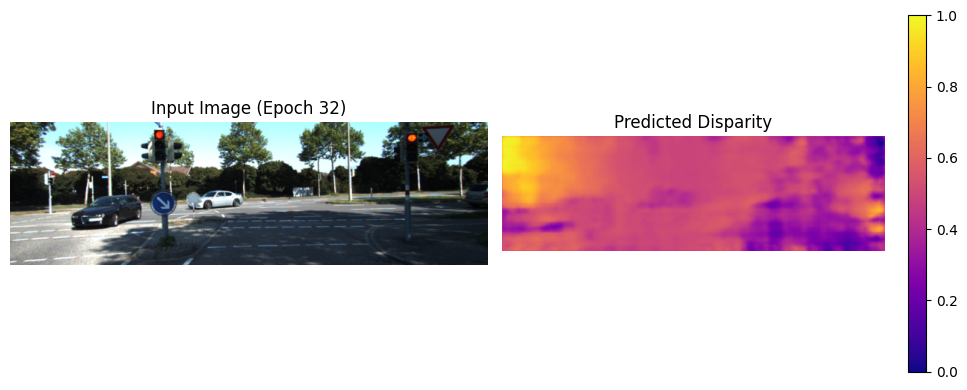


Epoch 33/40
  Step 0/138 - Loss: 0.2581
  Step 10/138 - Loss: 0.2852
  Step 20/138 - Loss: 0.2665
  Step 30/138 - Loss: 0.3060
  Step 40/138 - Loss: 0.2510
  Step 50/138 - Loss: 0.2760
  Step 60/138 - Loss: 0.2223
  Step 70/138 - Loss: 0.2388
  Step 80/138 - Loss: 0.2086
  Step 90/138 - Loss: 0.1979
  Step 100/138 - Loss: 0.2689
  Step 110/138 - Loss: 0.2513
  Step 120/138 - Loss: 0.2495
  Step 130/138 - Loss: 0.2783
Epoch 33 avg loss: 0.2474

Epoch 34/40
  Step 0/138 - Loss: 0.2678
  Step 10/138 - Loss: 0.2237
  Step 20/138 - Loss: 0.2976
  Step 30/138 - Loss: 0.2632
  Step 40/138 - Loss: 0.2370
  Step 50/138 - Loss: 0.2843
  Step 60/138 - Loss: 0.2255
  Step 70/138 - Loss: 0.2372
  Step 80/138 - Loss: 0.2073
  Step 90/138 - Loss: 0.2055
  Step 100/138 - Loss: 0.2322
  Step 110/138 - Loss: 0.2524
  Step 120/138 - Loss: 0.2487
  Step 130/138 - Loss: 0.2648
Epoch 34 avg loss: 0.2452


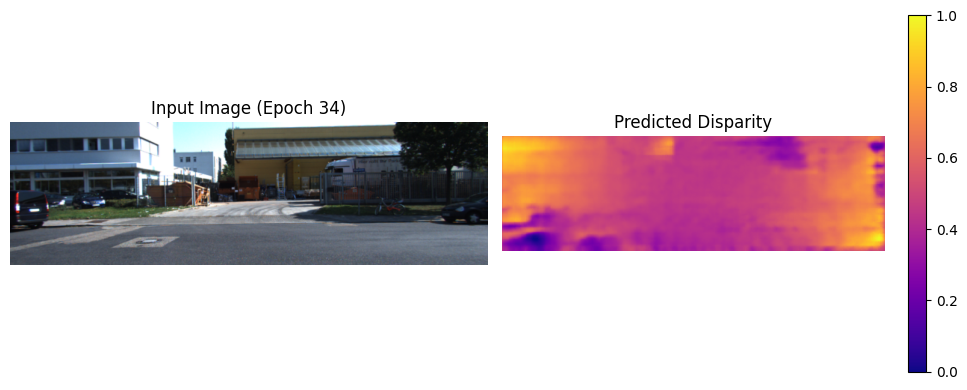


Epoch 35/40
  Step 0/138 - Loss: 0.2321
  Step 10/138 - Loss: 0.2076
  Step 20/138 - Loss: 0.2299
  Step 30/138 - Loss: 0.2622
  Step 40/138 - Loss: 0.2749
  Step 50/138 - Loss: 0.2412
  Step 60/138 - Loss: 0.2401
  Step 70/138 - Loss: 0.2325
  Step 80/138 - Loss: 0.2162
  Step 90/138 - Loss: 0.2570
  Step 100/138 - Loss: 0.2401
  Step 110/138 - Loss: 0.2386
  Step 120/138 - Loss: 0.2362
  Step 130/138 - Loss: 0.2564
Epoch 35 avg loss: 0.2445

Epoch 36/40
  Step 0/138 - Loss: 0.2491
  Step 10/138 - Loss: 0.2348
  Step 20/138 - Loss: 0.2383
  Step 30/138 - Loss: 0.2199
  Step 40/138 - Loss: 0.2181
  Step 50/138 - Loss: 0.2235
  Step 60/138 - Loss: 0.2121
  Step 70/138 - Loss: 0.2587
  Step 80/138 - Loss: 0.2481
  Step 90/138 - Loss: 0.2588
  Step 100/138 - Loss: 0.2354
  Step 110/138 - Loss: 0.2521
  Step 120/138 - Loss: 0.2790
  Step 130/138 - Loss: 0.1981
Epoch 36 avg loss: 0.2433


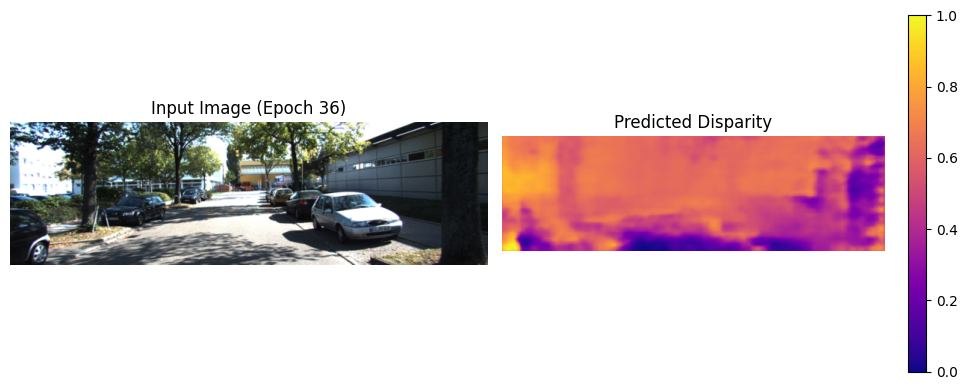


Epoch 37/40
  Step 0/138 - Loss: 0.2326
  Step 10/138 - Loss: 0.2301
  Step 20/138 - Loss: 0.2579
  Step 30/138 - Loss: 0.2315
  Step 40/138 - Loss: 0.2707
  Step 50/138 - Loss: 0.1746
  Step 60/138 - Loss: 0.2401
  Step 70/138 - Loss: 0.2999
  Step 80/138 - Loss: 0.2919
  Step 90/138 - Loss: 0.2322
  Step 100/138 - Loss: 0.2290
  Step 110/138 - Loss: 0.2465
  Step 120/138 - Loss: 0.2413
  Step 130/138 - Loss: 0.2458
Epoch 37 avg loss: 0.2427

Epoch 38/40
  Step 0/138 - Loss: 0.2247
  Step 10/138 - Loss: 0.2199
  Step 20/138 - Loss: 0.2221
  Step 30/138 - Loss: 0.2358
  Step 40/138 - Loss: 0.2781
  Step 50/138 - Loss: 0.2374
  Step 60/138 - Loss: 0.2456
  Step 70/138 - Loss: 0.1920
  Step 80/138 - Loss: 0.2186
  Step 90/138 - Loss: 0.2593
  Step 100/138 - Loss: 0.2648
  Step 110/138 - Loss: 0.2241
  Step 120/138 - Loss: 0.2227
  Step 130/138 - Loss: 0.2429
Epoch 38 avg loss: 0.2417


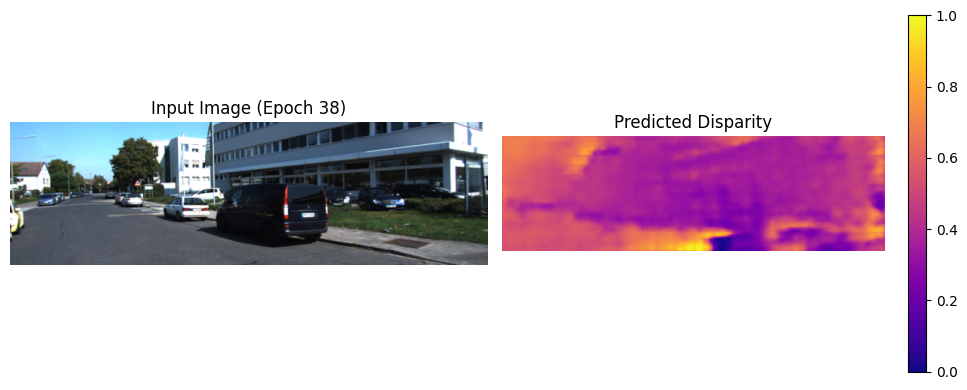


Epoch 39/40
  Step 0/138 - Loss: 0.2541
  Step 10/138 - Loss: 0.2102
  Step 20/138 - Loss: 0.2078
  Step 30/138 - Loss: 0.2587
  Step 40/138 - Loss: 0.2323
  Step 50/138 - Loss: 0.2694
  Step 60/138 - Loss: 0.2379
  Step 70/138 - Loss: 0.2910
  Step 80/138 - Loss: 0.2294
  Step 90/138 - Loss: 0.2484
  Step 100/138 - Loss: 0.2456
  Step 110/138 - Loss: 0.2545
  Step 120/138 - Loss: 0.2395
  Step 130/138 - Loss: 0.1874
Epoch 39 avg loss: 0.2406

Epoch 40/40
  Step 0/138 - Loss: 0.2004
  Step 10/138 - Loss: 0.2577
  Step 20/138 - Loss: 0.2542
  Step 30/138 - Loss: 0.2188
  Step 40/138 - Loss: 0.2785
  Step 50/138 - Loss: 0.2140
  Step 60/138 - Loss: 0.2283
  Step 70/138 - Loss: 0.2508
  Step 80/138 - Loss: 0.2282
  Step 90/138 - Loss: 0.2944
  Step 100/138 - Loss: 0.2569
  Step 110/138 - Loss: 0.2321
  Step 120/138 - Loss: 0.2560
  Step 130/138 - Loss: 0.2599
Epoch 40 avg loss: 0.2410


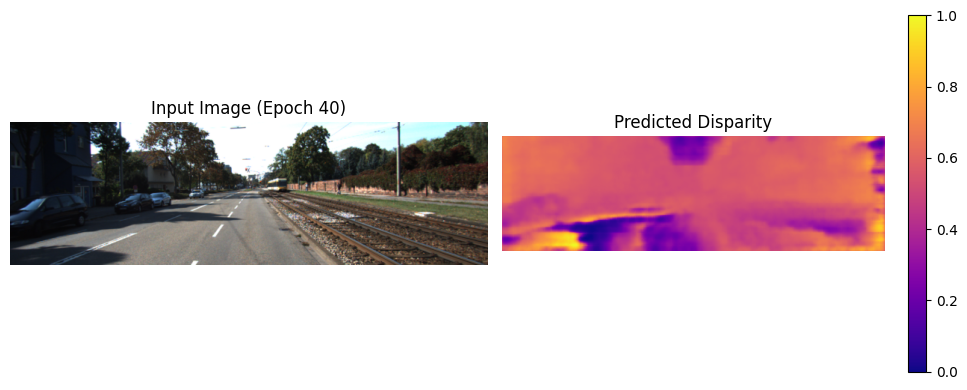

In [ ]:
# Initializing networks and optimizer
depth_net = DepthNetMultiScale().to(cfg.device)
pose_net = PoseNet().to(cfg.device)
optimizer = torch.optim.Adam(list(depth_net.parameters()) + list(pose_net.parameters()), lr=cfg.lr)

# Hyperparamaters for training and viewing progress
losses = []
save_preds_every = 2
num_epochs = 40

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_loss = 0

    for step, batch in enumerate(kitti_loader):
        img_t_minus = batch['t-1'].to(cfg.device)
        img_t       = batch['t'].to(cfg.device)
        img_t_plus  = batch['t+1'].to(cfg.device)

        # Depth prediction
        depth_preds = depth_net(img_t)
        depths = [1.0 / (d + 1e-6) for d in depth_preds]

        # This is where we use the PoseNet
        pose_min = pose_net(img_t, img_t_minus)
        pose_max  = pose_net(img_t, img_t_plus)
        T_t_to_minus = pose_vec_to_matrix(pose_min)
        T_t_to_plus  = pose_vec_to_matrix(pose_max)

        K = make_intrinsics_matrix(img_t.shape[0], cfg.img_height, cfg.img_width, cfg.device)

        # Using the loss we previously defined
        loss = multi_scale_loss(depths, img_t, img_t_minus, img_t_plus, T_t_to_minus, T_t_to_plus, K)

        # Learning Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        epoch_loss += loss.item()

        if step % 10 == 0:
            print(f"  Step {step}/{len(kitti_loader)} - Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} avg loss: {epoch_loss / len(kitti_loader):.4f}")

    # Visualizing the disparity map after every two epochs
    if (epoch + 1) % save_preds_every == 0:
        with torch.no_grad():
            disp_vis = depth_preds[0][0, 0].detach().cpu()
            disp_vis = (disp_vis - disp_vis.min()) / (disp_vis.max() - disp_vis.min() + 1e-8)

            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(batch['t'][0].permute(1, 2, 0).cpu())
            plt.title(f"Input Image (Epoch {epoch+1})")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(disp_vis, cmap='plasma')
            plt.title("Predicted Disparity")
            plt.axis('off')
            plt.colorbar()
            plt.tight_layout()
            plt.show()


## Training Loss Curve

This cell plots the raw and smoothed photometric loss over training iterations.  
The moving average helps visualize the trend and convergence of the model. This is useful for debugging and evaluating training stability.


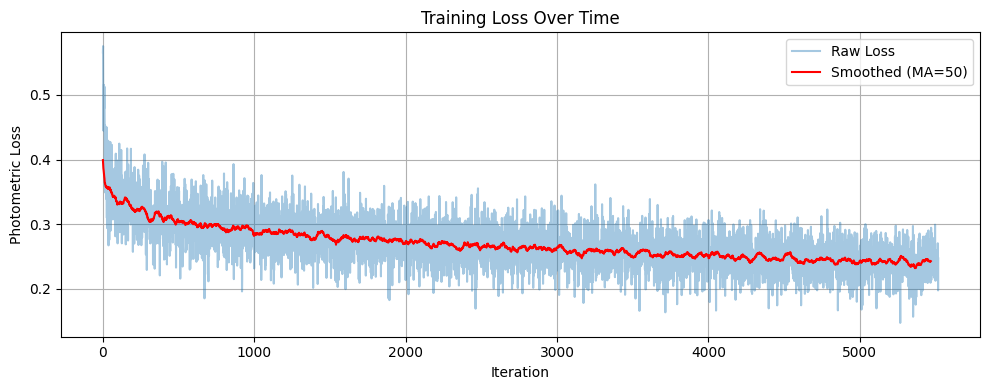

In [ ]:
def moving_average(x, w=50):
    return np.convolve(x, np.ones(w)/w, mode='valid')

plt.figure(figsize=(10, 4))
plt.plot(losses, label="Raw Loss", alpha=0.4)
plt.plot(moving_average(losses), label="Smoothed (MA=50)", color='red')
plt.xlabel("Iteration")
plt.ylabel("Photometric Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Training Evaluation: Disparity Map Visualization

This cell randomly samples five images from the training dataset and uses the trained depth network to generate disparity predictions.  
Each predicted disparity map is visualized next to its corresponding input image to qualitatively assess model performance after training.


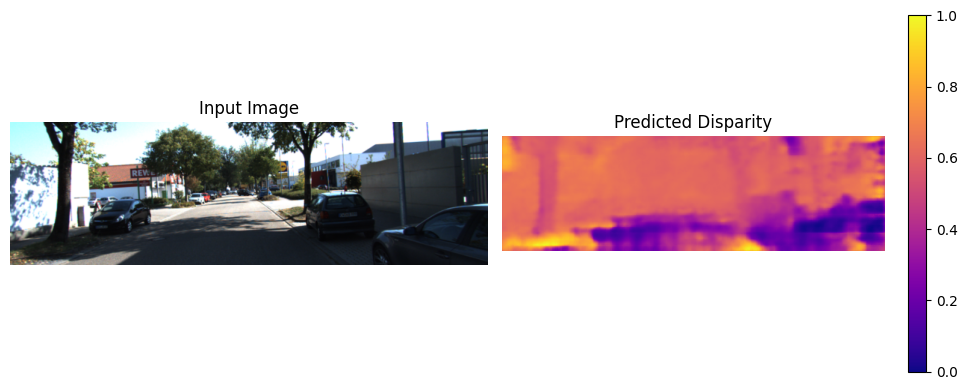

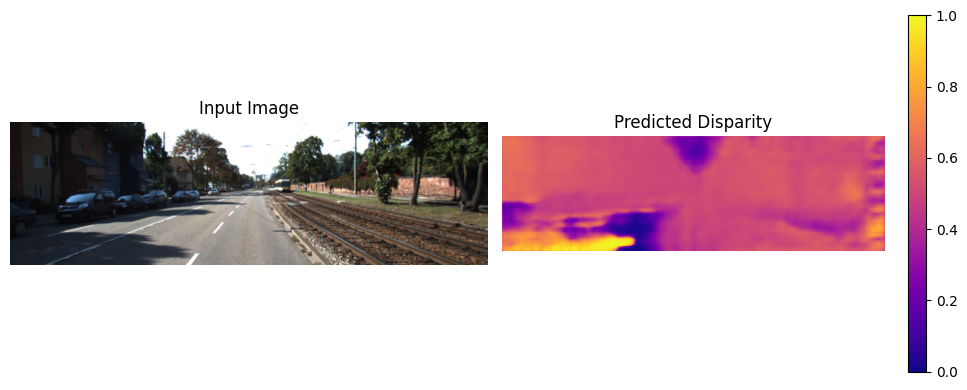

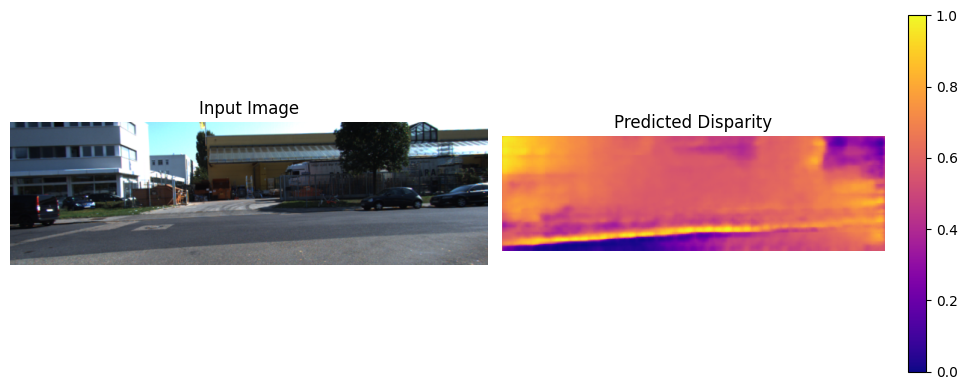

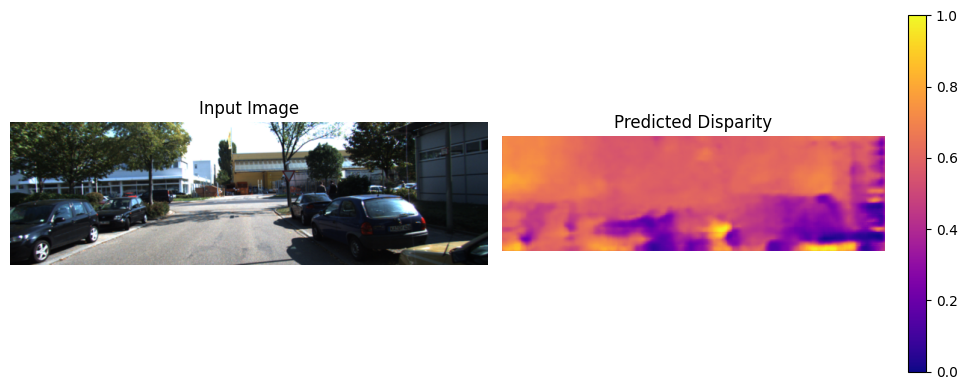

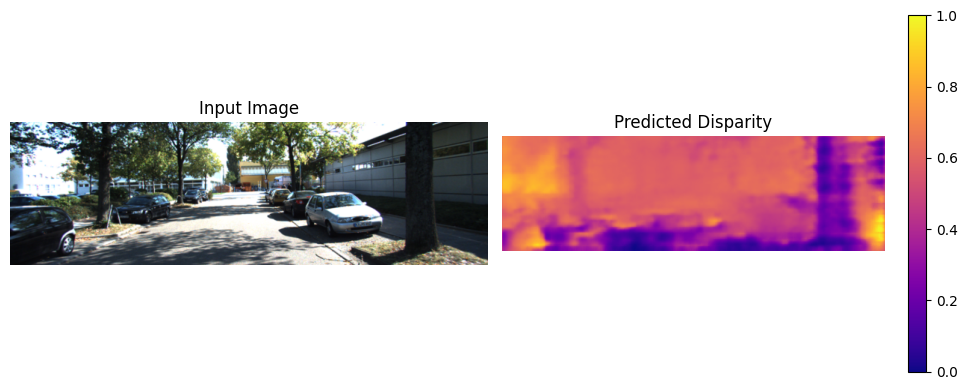

In [ ]:
import random

depth_net.eval()
n_samples = 5

for i in range(n_samples):
    idx = random.randint(0, len(kitti_dataset) - 1)
    sample = kitti_dataset[idx]

    img = sample['t'].unsqueeze(0).to(cfg.device)  # shape: [1, 3, H, W]
    with torch.no_grad():
        depth_preds = depth_net(img)
        disp = depth_preds[0][0, 0].detach().cpu()  # use scale 1

    # Normalizing disparity here
    disp_norm = (disp - disp.min()) / (disp.max() - disp.min() + 1e-8)
    img_np = sample['t'].permute(1, 2, 0).cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(disp_norm, cmap='plasma')
    plt.title("Predicted Disparity")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


## Conclusion

- We implement a self-supervised learning framework for monocular depth estimation based on the Monodepth methodology. Using only temporally adjacent unlabelled video frames, the system learns to anticipate dense disparity maps from single RGB images. Our performance on the KITTI dataset was reasonable thanks to the combination of multi-scale depth estimation, relative pose prediction, view synthesis, and photometric losses (such as SSIM and automasking). This allowed us to capture large scene structures and depth gradients without the need for explicit ground-truth depth supervision.

- This project's model architecture was built on a 4-stage decoder and a ResNet18 encoder, which generate disparity predictions at various resolutions.  One possible improvement would definitely be to extract richer visual information at the expense of more processing by using a deeper encoder, like RResNet50. The quality of upsampled disparity predictions may also be enhanced by adding connections at further levels or by increasing the number of convolutional layers in the decoder, particularly for object borders.

- Employing more depth levels (for example, predicting six or more scales rather than four) might enable more accurate multiresolution supervision and possibly stabilise training. We could expand the batch size, input image resolution, and model capacity if we had access to more powerful computational resources, including a more potent GPU (like the A100 or RTX 3090). This would speed up convergence in addition to improving performance. Additionally, methods such as temporal consistency restrictions, test-time augmentation, or the incorporation of attention mechanisms may improve the model's accuracy and resilience in dynamic or obscured settings.

- Our current results do not outline all the objects in the images to the best of our liking, but adding more depth layers, more computation power and increasing the dataset size would definitely improve these results. However, the results do show this happening to a certain extent and goes to show that we can scale this up and build something that can go into the market with all the improvements and tweaks we suggest here.

- All things considered, our effort shows the scalability, usefulness, and adaptability of self-supervised monocular depth estimation techniques, particularly in real-world applications like autonomous driving where finding labelled data is costly.
